#Run Image GPT with [Transformers](https://github.com/huggingface/transformers)
by [Alfredo Peguero](https://twitter.com/alfredompeguero)

# Download Image GPT

In [1]:
!git clone https://github.com/openai/image-gpt.git

fatal: destination path 'image-gpt' already exists and is not an empty directory.


In [2]:
model_sizes = ["s", "m", "l"] #small medium large, xl not available
model_size = "s"
models_dir = "/content/models"
color_clusters_dir = "/content/clusters"
bs = 5
n_px = 32

In [3]:
!python image-gpt/download.py --model {model_size} --ckpt 1000000 --clusters --dataset imagenet --download_dir {models_dir}/{model_size}
!python image-gpt/download.py --clusters --download_dir {color_clusters_dir}

input args:
 {
    "download_dir":"/content/models/s",
    "bert":false,
    "model":"s",
    "ckpt":"1000000",
    "clusters":true,
    "dataset":"imagenet"
}
Fetching model.ckpt-1000000.data-00000-of-00032: 1.00kit [00:00, 735kit/s]      
Fetching model.ckpt-1000000.data-00001-of-00032: 31.5Mit [00:10, 2.95Mit/s]     
Fetching model.ckpt-1000000.data-00002-of-00032: 28.3Mit [00:03, 7.34Mit/s]     
Fetching model.ckpt-1000000.data-00003-of-00032: 28.3Mit [00:10, 2.82Mit/s]     
Fetching model.ckpt-1000000.data-00004-of-00032: 28.3Mit [00:12, 2.21Mit/s]     
Fetching model.ckpt-1000000.data-00005-of-00032: 31.5Mit [00:12, 2.51Mit/s]     
Fetching model.ckpt-1000000.data-00006-of-00032: 30.4Mit [00:03, 7.71Mit/s]     
Fetching model.ckpt-1000000.data-00007-of-00032: 28.3Mit [00:11, 2.55Mit/s]     
Fetching model.ckpt-1000000.data-00008-of-00032: 31.5Mit [00:10, 2.92Mit/s]     
Fetching model.ckpt-1000000.data-00009-of-00032: 29.4Mit [00:04, 6.83Mit/s]     
Fetching model.ckpt-1000000.da

# Subclass GPT2LMHeadModel


In [4]:
!pip install transformers

In [5]:
import os
import transformers
from transformers.models.gpt2.modeling_gpt2 import GPT2Model,GPT2LMHeadModel
import torch
import torch.nn as nn
import logging
logger = logging.getLogger(__name__)

def load_tf_weights_in_image_gpt2(model, config, gpt2_checkpoint_path):
    """ Load tf checkpoints in a pytorch model
    """
    try:
        import re
        import tensorflow as tf
    except ImportError:
        logger.error(
            "Loading a TensorFlow model in PyTorch, requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ for installation instructions."
        )
        raise
    tf_path = os.path.abspath(gpt2_checkpoint_path)
    logger.info("Converting TensorFlow checkpoint from {}".format(tf_path))
    # Load weights from TF model
    init_vars = tf.train.list_variables(tf_path)
    names = []
    arrays = []

    for name, shape in init_vars:
        logger.info("Loading TF weight {} with shape {}".format(name, shape))
        array = tf.train.load_variable(tf_path, name)
        names.append(name)
        arrays.append(array.squeeze())

    for name, array in zip(names, arrays):
        name = name[6:]  # skip "model/"
        name = name.split("/")

        # adam_v and adam_m are variables used in AdamWeightDecayOptimizer to calculated m and v
        # which are not required for using pretrained model
        if any(
            n in ["adam_v", "adam_m", "AdamWeightDecayOptimizer", "AdamWeightDecayOptimizer_1", "global_step"]
            for n in name
        ) or name[-1] in ['_step']:
            logger.info("Skipping {}".format("/".join(name)))
            continue
        
        pointer = model
        if name[-1] not in ["wtet"]:
          pointer = getattr(pointer, "transformer")
        
        for m_name in name:
            if re.fullmatch(r"[A-Za-z]+\d+", m_name):
                scope_names = re.split(r"(\d+)", m_name)
            else:
                scope_names = [m_name]

            if scope_names[0] == "w" or scope_names[0] == "g":
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "b":
                pointer = getattr(pointer, "bias")
            elif scope_names[0] == "wpe" or scope_names[0] == "wte":
                pointer = getattr(pointer, scope_names[0])
                pointer = getattr(pointer, "weight")
            elif scope_names[0] in ['q_proj','k_proj','v_proj']:
                pointer = getattr(pointer, 'c_attn')
                pointer = getattr(pointer, 'weight')
            elif len(name) ==3 and name[1]=="attn" and scope_names[0]=="c_proj":
                pointer = getattr(pointer, scope_names[0])
                pointer = getattr(pointer, 'weight')
            elif scope_names[0]=="wtet":
                pointer = getattr(pointer, "lm_head")
                pointer = getattr(pointer, 'weight')
            elif scope_names[0]=="sos":
                pointer = getattr(pointer,"wte")
                pointer = getattr(pointer, 'weight')
            else:
                pointer = getattr(pointer, scope_names[0])
            if len(scope_names) >= 2:
                num = int(scope_names[1])
                pointer = pointer[num]

        if len(name) > 1 and name[1]=="attn" or name[-1]=="wtet" or name[-1]=="sos" or name[-1]=="wte":
           pass #array is used to initialize only part of the pointer so sizes won't match
        else:
          try:
              assert pointer.shape == array.shape
          except AssertionError as e:
              e.args += (pointer.shape, array.shape)
              raise
          
        logger.info("Initialize PyTorch weight {}".format(name))

        if name[-1]=="q_proj":
          pointer.data[:,:config.n_embd] = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) ).T
        elif name[-1]=="k_proj":
          pointer.data[:,config.n_embd:2*config.n_embd] = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) ).T
        elif name[-1]=="v_proj":
          pointer.data[:,2*config.n_embd:] = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) ).T
        elif (len(name) ==3 and name[1]=="attn" and name[2]=="c_proj" ):
          pointer.data = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) )
        elif name[-1]=="wtet":
          pointer.data = torch.from_numpy(array)
        elif name[-1]=="wte":
          pointer.data[:config.vocab_size-1,:] = torch.from_numpy(array)
        elif name[-1]=="sos":
          pointer.data[-1] = torch.from_numpy(array)
        else:
          pointer.data = torch.from_numpy(array)

    return model


from torch.nn.parameter import Parameter
class ln_mod(nn.Module):
    def __init__(self, nx,eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = Parameter(torch.Tensor(nx))
    def forward(self,x):#input is not mean centered
        return x / torch.sqrt( torch.std(x,axis=-1,unbiased=False,keepdim=True)**2 + self.eps ) * self.weight.data[...,:] 

def replace_ln(m, name,config):
  for attr_str in dir(m):
      target_attr = getattr(m, attr_str)
      if type(target_attr) == torch.nn.LayerNorm:
          #print('replaced: ', name, attr_str)
          setattr(m, attr_str, ln_mod(config.n_embd,config.layer_norm_epsilon))

  for n, ch in m.named_children():
      replace_ln(ch, n,config)        

def gelu2(x):
    return x * torch.sigmoid(1.702 * x)

class ImageGPT2LMHeadModel(GPT2LMHeadModel):
  load_tf_weights = load_tf_weights_in_image_gpt2
  
  def __init__(self, config):
      super().__init__(config)
      self.lm_head = nn.Linear(config.n_embd, config.vocab_size - 1, bias=False)
      replace_ln(self,"net",config) #replace layer normalization
      for n in range(config.n_layer):
        self.transformer.h[n].mlp.act = gelu2 #replace activation 

  def tie_weights(self): #image-gpt doesn't tie output and input embeddings
    pass 

# Unconditional Image Generation

In [6]:
import numpy as np
color_clusters_file = "%s/kmeans_centers.npy"%(color_clusters_dir)
clusters = np.load(color_clusters_file) #get color clusters

In [7]:
MODELS={"l":(1536,16,48),"m":(1024,8,36),"s":(512,8,24) } 
n_embd,n_head,n_layer=MODELS[model_size] #set model hyperparameters
vocab_size = len(clusters) + 1 #add one for start of sentence token
config = transformers.GPT2Config(vocab_size=vocab_size,n_ctx=n_px*n_px,n_positions=n_px*n_px,n_embd=n_embd,n_layer=n_layer,n_head=n_head)
model_path = "%s/%s/model.ckpt-1000000.index"%(models_dir,model_size)

model = ImageGPT2LMHeadModel.from_pretrained(model_path,from_tf=True,config=config).cuda()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [8]:
context = np.full( (bs,1), vocab_size - 1 ) #initialize with SOS token
context = torch.tensor(context).cuda()
output = model.generate(input_ids=context,max_length= n_px*n_px + 1,temperature=1.0,do_sample=True,top_k=40)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


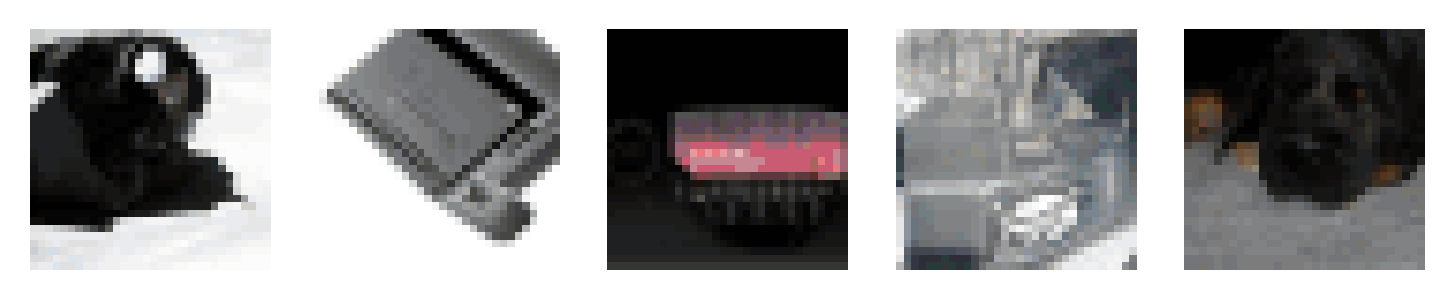

In [9]:
#visualize samples with Image-GPT color palette.
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

samples = output[:,1:].cpu().detach().numpy()
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
f, axes = plt.subplots(1,bs,dpi=300)

for img,ax in zip(samples_img,axes):
    ax.axis('off')
    ax.imshow(img)
    

# Tokenize Cropped Images for Image Completion

In [10]:
#numpy implementation of functions in image-gpt/src/utils which convert pixels of image to nearest color cluster. 
def normalize_img(img):
  return img/127.5 - 1

def squared_euclidean_distance_np(a,b):
  b = b.T
  a2 = np.sum(np.square(a),axis=1)
  b2 = np.sum(np.square(b),axis=0)
  ab = np.matmul(a,b)
  d = a2[:,None] - 2*ab + b2[None,:]
  return d

def color_quantize_np(x, clusters):
    x = x.reshape(-1, 3)
    d = squared_euclidean_distance_np(x, clusters)
    return np.argmin(d,axis=1)

In [11]:
#get images
!curl https://i.imgur.com/fIiwqyn.jpeg > sg.jpeg
image_paths = ["sg.jpeg"]*bs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  746k  100  746k    0     0  6017k      0 --:--:-- --:--:-- --:--:-- 6017k


In [12]:
#Resize original images to n_px by n_px
import cv2
import numpy as np
dim=(n_px,n_px)

x = np.zeros((bs,n_px,n_px,3),dtype=np.uint8)

for n,image_path in enumerate(image_paths):
  img_np = cv2.imread(image_path)   # reads an image in the BGR format
  img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)   # BGR -> RGB
  H,W,C = img_np.shape
  D = min(H,W)
  img_np = img_np[:D,:D,:C] #get square piece of image
  x[n] = cv2.resize(img_np,dim, interpolation = cv2.INTER_AREA) #resize to n_px by n_px
  

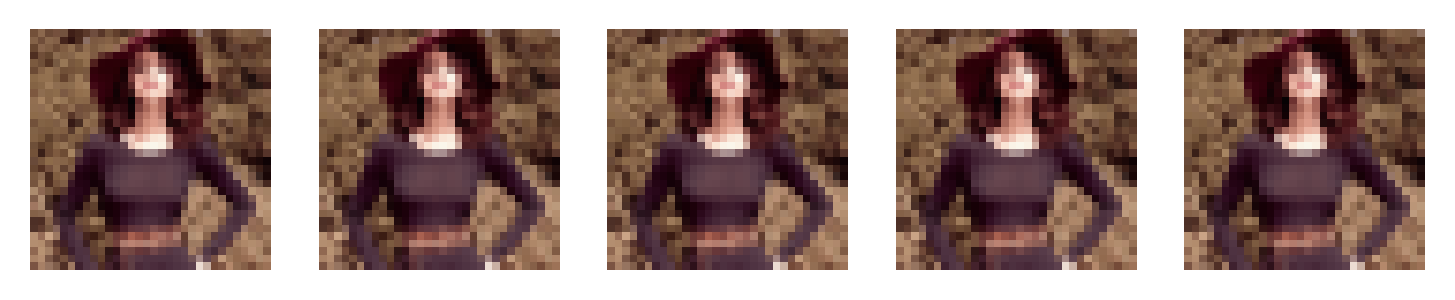

In [13]:
#visualize resized images
f, axes = plt.subplots(1,bs,dpi=300)

for img,ax in zip(x,axes):
    ax.axis('off')
    ax.imshow(img)

In [14]:
#use Image-GPT color palette and crop images
x_norm = normalize_img(x) #normalize pixels values to -1 to +1
samples = color_quantize_np(x_norm,clusters).reshape(x_norm.shape[:-1]) #map pixels to closest color cluster

n_px_crop = 16
primers = samples.reshape(-1,n_px*n_px)[:,:n_px_crop*n_px] # crop top n_px_crop rows. These will be the conditioning tokens

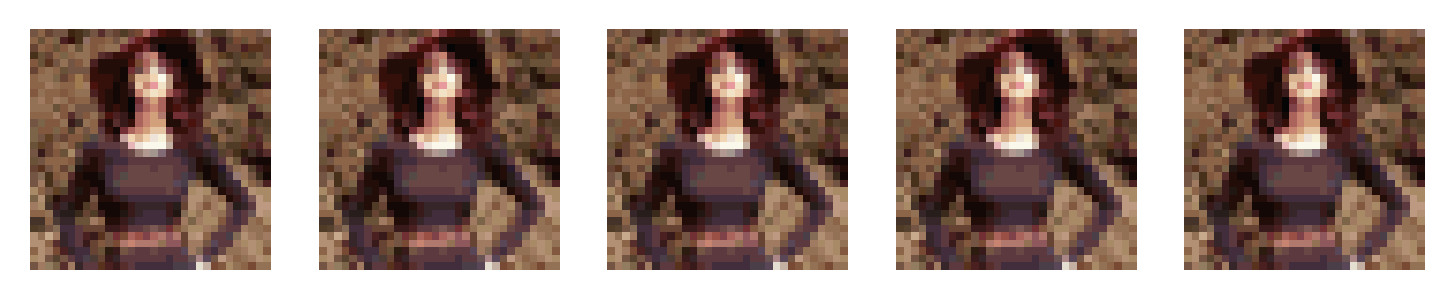

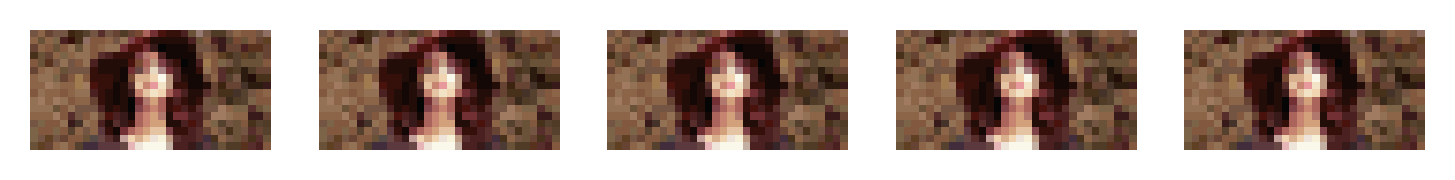

In [15]:
#visualize samples and crops with Image-GPT color palette. Should look similar to original resized images
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color clusters back to pixels
primers_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px_crop,n_px, 3]).astype(np.uint8) for s in primers] # convert color clusters back to pixels


f, axes = plt.subplots(1,bs,dpi=300)
for img,ax in zip(samples_img,axes):
    ax.axis('off')
    ax.imshow(img)

f, axes2 = plt.subplots(1,bs,dpi=300)
for img,ax in zip(primers_img,axes2):
    ax.axis('off')
    ax.imshow(img)

# Conditional Image Completion

In [16]:
context = np.concatenate( (np.full( (bs,1), vocab_size - 1 ),primers,), axis=1 )
context = torch.tensor(context).cuda()
output = model.generate(input_ids=context,max_length= n_px*n_px + 1,temperature=1.0,do_sample=True,top_k=40)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


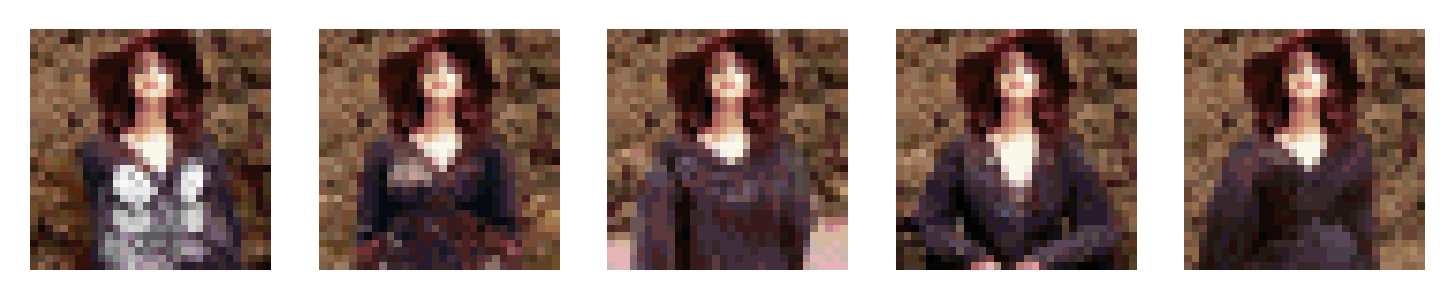

In [17]:
#visualize samples with Image-GPT color palette. 

samples = output[:,1:].cpu().detach().numpy()
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
f, axes = plt.subplots(1,bs,dpi=300)

for img,ax in zip(samples_img,axes):
    ax.axis('off')
    ax.imshow(img)
    

In [18]:
#get images
# !curl https://github.com/chhatbarnikita/image/blob/main/index3.jpeg > sg.jpeg
image_pathss = ["4220549.jpg", "4220550.jpg", "4220551.jpg", "4220553.jpg", "4220556.jpg"]

In [19]:
#Resize original images to n_px by n_px
import cv2
import numpy as np
dim=(n_px,n_px)

x = np.zeros((5,n_px,n_px,3),dtype=np.uint8)

for n,image_path in enumerate(image_pathss):
  img_np = cv2.imread(image_path)   # reads an image in the BGR format
  img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)   # BGR -> RGB
  H,W,C = img_np.shape
  D = min(H,W)
  img_np = img_np[:D,:D,:C] #get square piece of image
  x[n] = cv2.resize(img_np,dim, interpolation = cv2.INTER_AREA) #resize to n_px by n_px
  

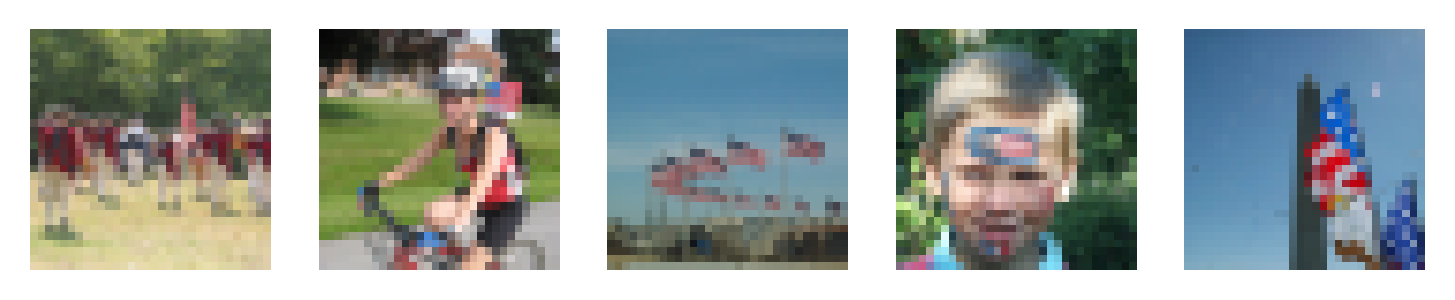

In [20]:
#visualize resized images
f, axes = plt.subplots(1,5,dpi=300)

for img,ax in zip(x,axes):
    ax.axis('off')
    ax.imshow(img)

In [21]:
#use Image-GPT color palette and crop images
x_norm = normalize_img(x) #normalize pixels values to -1 to +1
samples = color_quantize_np(x_norm,clusters).reshape(x_norm.shape[:-1]) #map pixels to closest color cluster

n_px_crop = 24
primers = samples.reshape(-1,n_px*n_px)[:,:n_px_crop*n_px] # crop top n_px_crop rows. These will be the conditioning tokens

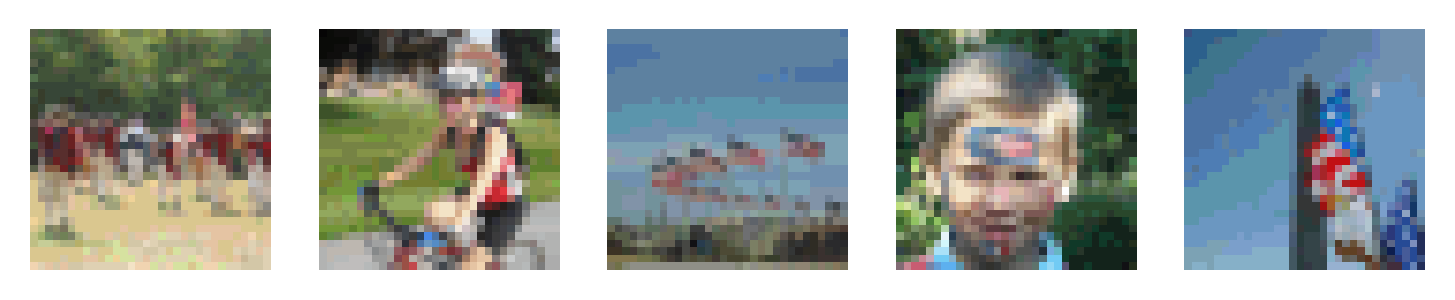

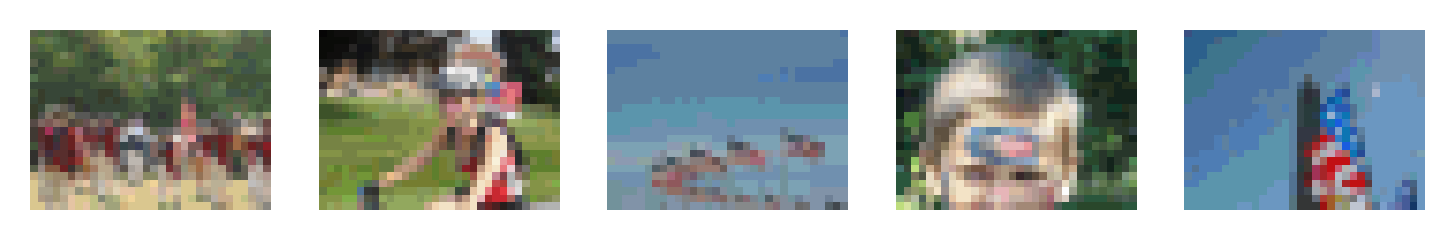

In [22]:
#visualize samples and crops with Image-GPT color palette. Should look similar to original resized images
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color clusters back to pixels
primers_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px_crop,n_px, 3]).astype(np.uint8) for s in primers] # convert color clusters back to pixels


f, axes = plt.subplots(1,5,dpi=300)
for img,ax in zip(samples_img,axes):
    ax.axis('off')
    ax.imshow(img)

f, axes2 = plt.subplots(1,5,dpi=300)
for img,ax in zip(primers_img,axes2):
    ax.axis('off')
    ax.imshow(img)

In [23]:
context = np.concatenate( (np.full( (5,1), vocab_size - 1 ),primers,), axis=1 )
context = torch.tensor(context).cuda()
output = model.generate(input_ids=context,max_length= n_px*n_px + 1,temperature=1.0,do_sample=True,top_k=40)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


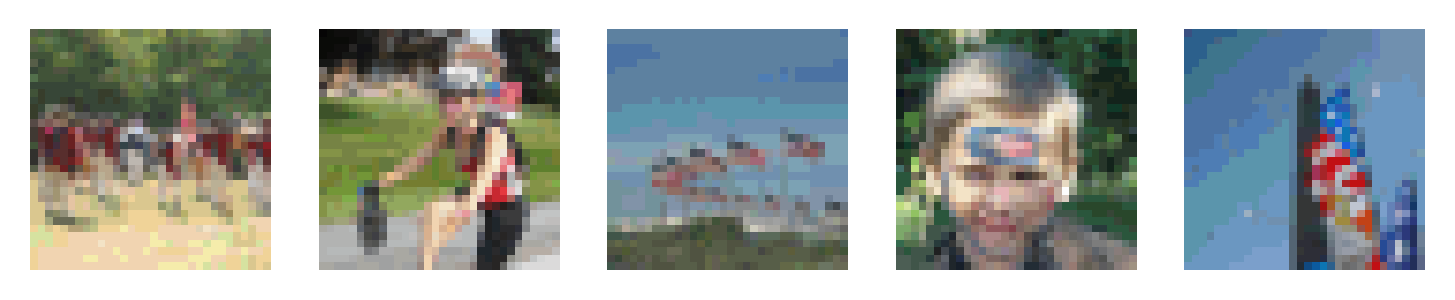

In [24]:
#visualize samples with Image-GPT color palette. 

samples = output[:,1:].cpu().detach().numpy()
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
f, axes = plt.subplots(1,5,dpi=300)

for img,ax in zip(samples_img,axes):
    ax.axis('off')
    ax.imshow(img)
    

In [25]:
i = 0
for img,ax in zip(samples_img,axes):
    ax.axis('off')
    ax.imshow(img)
    name = f'img{i}'+'.jpg'
    print(name)
    i += 1
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(name, img)

img0.jpg
img1.jpg
img2.jpg
img3.jpg
img4.jpg


In [26]:
# !python image-gpt/download.py --model s --ckpt 1000000 --dataset imagenet


In [48]:
!pip install tensorflow==1.13.1
!pip install tensorflow-gpu==1.13.1

!python -c 'import tensorflow as tf; print(tf.__version__);'
!python image-gpt/src/run.py --eval --n_embd 512  --n_head 8  --n_layer 24 --ckpt_path /content/models/s/model.ckpt-1000000 --color_cluster_path /content/models/s/ --save_dir /content/models/s/

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [49]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
